# BI8040 course - Logical Modeling for Experimental Design in Biotechnology and Biomedicine

## Notebook project of Eirini Tsirvouli & Vasundra Touré

The model of interest in this notebook is the __Mammalian cell cycle__ based on the publication of *Traynard et al.*: [Logical model specification aided by model-checking techniques: application to the mammalian cell cycle regulation](https://doi.org/10.1093/bioinformatics/btw457). 

This project aims to acquire knowledge and a first hands-on on tools for logical modelling and analysis: bioLQM library, GINsim, MaBoSS, Pint and NuSMV.
We show here an attempt to reproduce the results from the paper cited previously and find alternative ways to study the Cell Cycle model in order to eventually gain new insights. 

The diagram below represent the different nodes' activities depending on the phase:

<html>
    <img src="./Cell_cycle.png" width =500>
</html>

### Imports and model loading with GINsim
The first thing to do is to import the necessary tools for performing our analysis.


In [1]:
import ginsim 
import biolqm
import maboss
import pypint
from colomoto_jupyter import tabulate
from colomoto.temporal_logics import *
from itertools import combinations
from functools import reduce

import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas import DataFrame

You are using Pint version 2018-03-22 and pypint 1.4.1

Then we load the model using GINsim. In our case, the model is available online with the .zginml format at [http://ginsim.org/sites/default/files/Traynard_MultiLevel_MamCC_Apr2016.zginml](http://ginsim.org/sites/default/files/Traynard_MultiLevel_MamCC_Apr2016.zginml). 

In this project, we have decided to add two output nodes corresponding to two phenotype observed in the model for interpretation purposes: 
* __Proliferation__: when reaching this phenotype, the cell is cycling.
* __Q0_arrest__: when reaching this phenotype, the cell is in the quiescent phase.

This extended model is called *lrg_outputs* in this notebook.

In [2]:
lrg = ginsim.load("http://ginsim.org/sites/default/files/Traynard_MultiLevel_MamCC_Apr2016.zginml")
lrg_outputs = ginsim.load("./model_outputs.zginml")

Downloading 'http://ginsim.org/sites/default/files/Traynard_MultiLevel_MamCC_Apr2016.zginml'

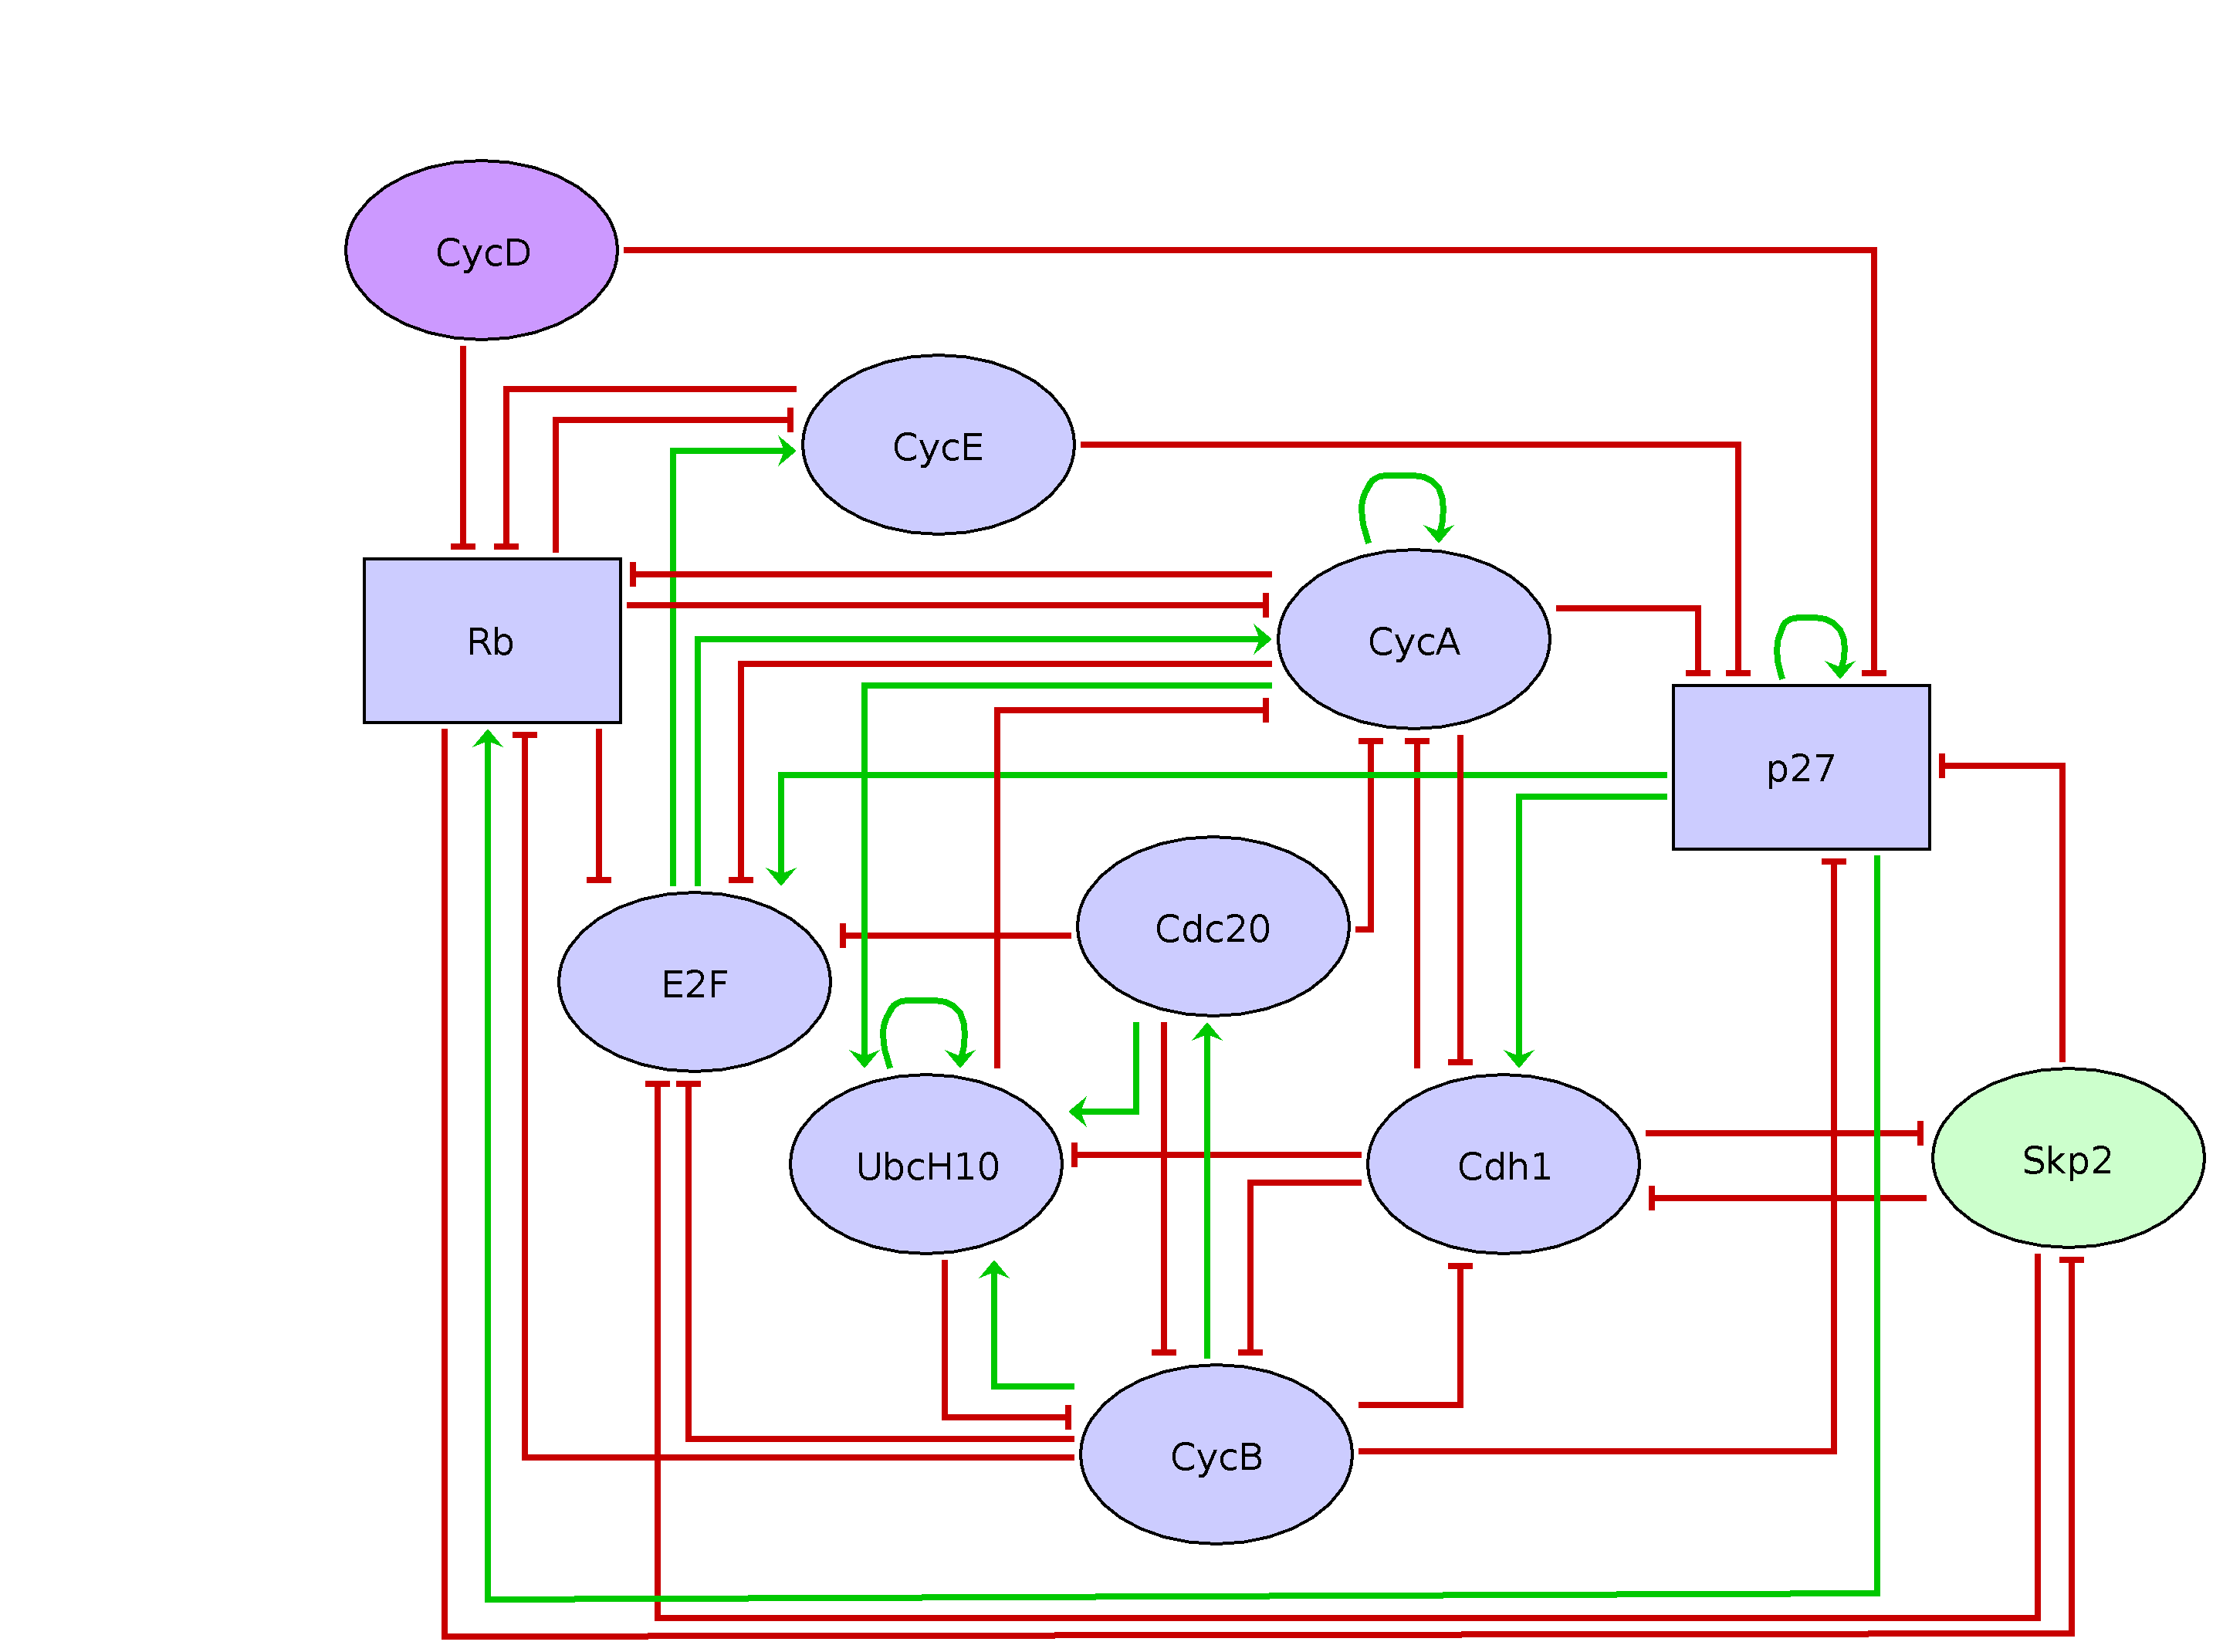

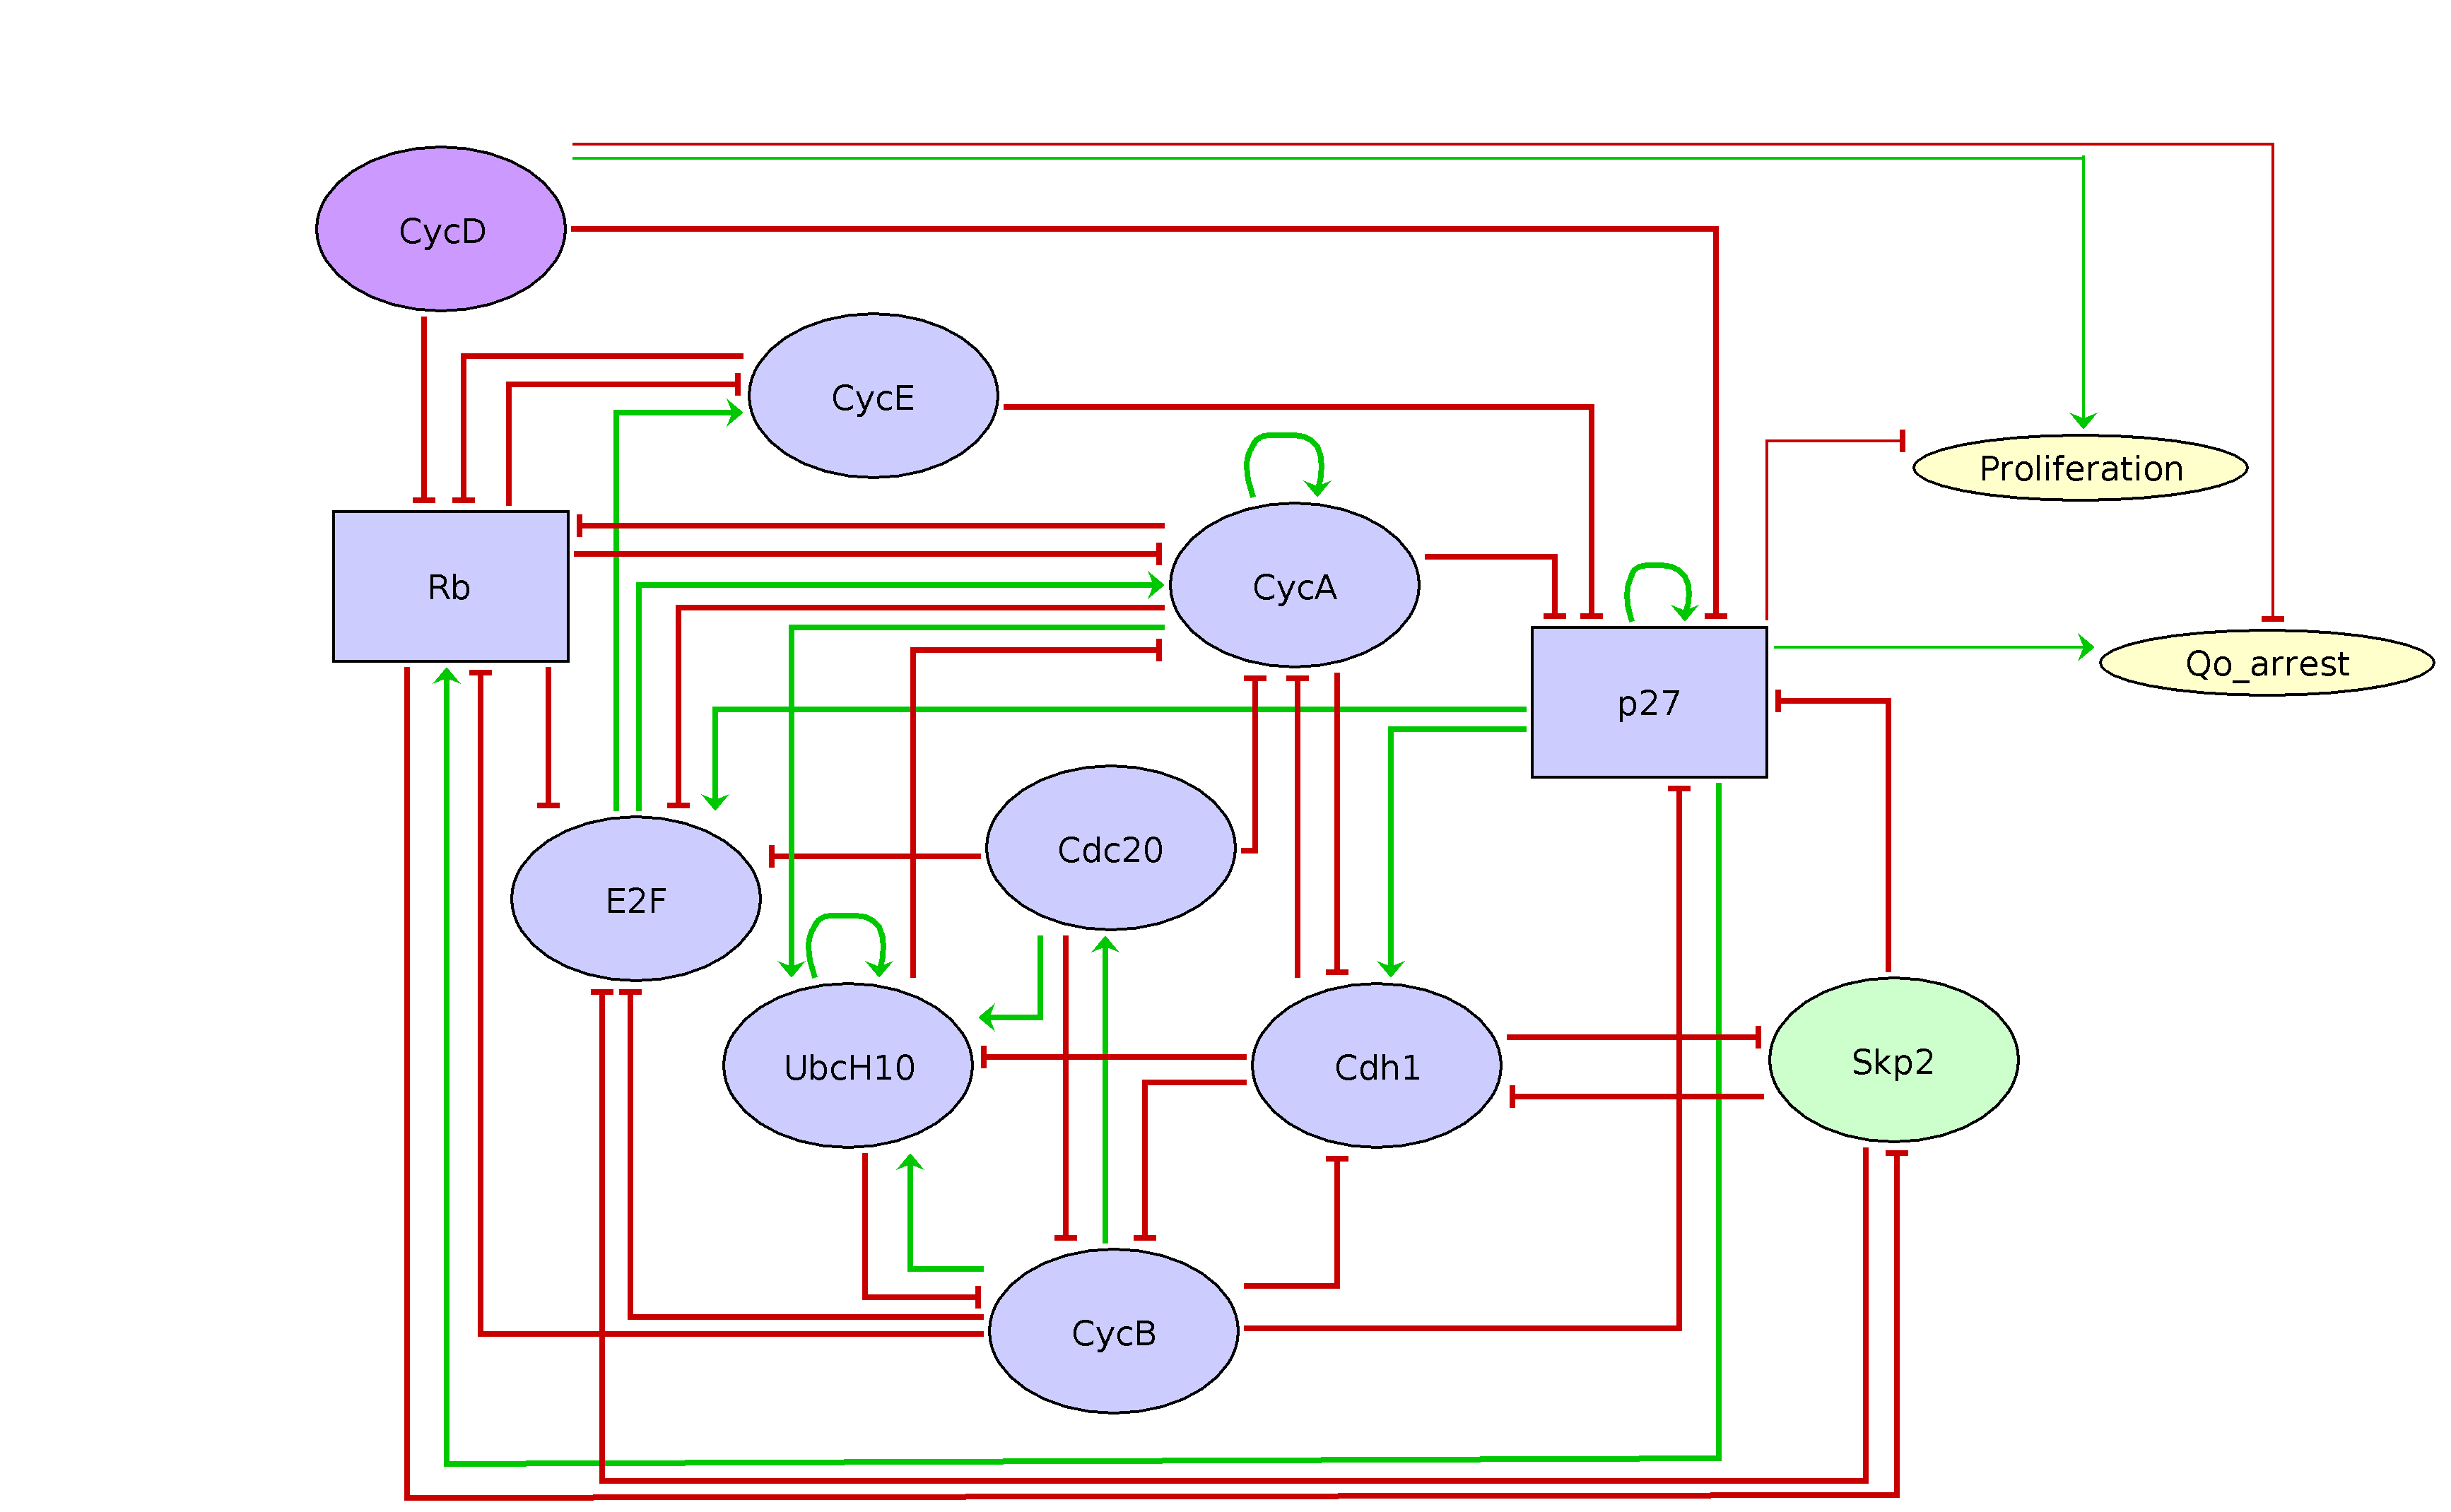

In [83]:
'''Visualisation of the model using a GINsim graph view'''
'''sys.displayhook allows to print multiple calls from a single Jupyter notebook cell - by default, only the last 'print' is shown.'''
sys.displayhook(ginsim.show(lrg))
sys.displayhook(ginsim.show(lrg_outputs))


### Identification of attractors (bioLQM)

The first analysis ran by *Traynard et al.* tries to characterise in their model, the different possible states of the Cell Cycle: the cycle itself and the quiscent state Q0. This is possible by computing the attractors of the model using either GINsim or bioLQM. 
At that time, *Traynard et al.* used GINsim and found 3 attractors: 1 cycle corresponding to the cell cycle, and 2 stable states corresponding to the quiscent state. The existence of these two stable states to represent the quiscent state is a limitation of the model in the level of CycA, mentioned by *Traynard et al.*: the degradation of CycA needs refined rules/regulators in this model. 

Nonetheless, we attempt to reproduce this result by computing first a trap spaces analysis using bioLQM (a library tool to manipulate and analyse logical models, mainly extracted from GINsim). The trap spaces will find attractor states from which the model can not escape from. It can be either a cyclic attractor or a stable state.

#### Trap space analysis to find the attractors of the model

In [3]:
'''Convert ginsim model to a biolqm compliant model '''
lqm = ginsim.to_biolqm(lrg)

In [4]:
'''Compute trap space analysis'''
traps = biolqm.trapspace(lqm)
tabulate(traps)

|    |   CycD |   Rb_b1 |   Rb_b2 |   E2F |   CycE |   CycA |   CycB |   p27_b1 |   p27_b2 |   Cdc20 |   Cdh1 |   UbcH10 |   Skp2 |
|---:|-------:|--------:|--------:|------:|-------:|-------:|-------:|---------:|---------:|--------:|-------:|---------:|-------:|
|  0 |      1 |     255 |       0 |   255 |    255 |    255 |    255 |      255 |        0 |     255 |    255 |      255 |      1 |
|  1 |      0 |       1 |       1 |     0 |      0 |      1 |      0 |        1 |        1 |       0 |      1 |        0 |      0 |
|  2 |      0 |       1 |       1 |     0 |      0 |      0 |      0 |        1 |        1 |       0 |      1 |        0 |      0 |

The trap space analysis gives us 3 attractors: 
* one cyclic attractor in which:
    * the CycD is set to 1, so we are in the cell cycle and not in the quiescent state
    * the inhibitor Rb is not unphosphorylated and the activity of p27 is never set to 2, meaning we are not in the quiescent state
    * the activity of the other cyclins (CycA, CyCb, CycE) oscillates between 0 and 1, confirming again that we are in the cell cycle.
* two stable states where:
    * CycD=0 and the inhibitors are active, meaning we are in the quiscent state
    * the only difference is the activity of CycA, corresponding to the limitation mentionned in the paper.    


In order to double check our results and show an alternative way to compute the attractors, we use the fixpoints function from bioLQM. However, in this case, only stable states can be retrieved. 

We visualise each stable state obtained in a graph that highlights the active components (yellow nodes) and the trajectories (blue arcs) taken with a GINsim function. 

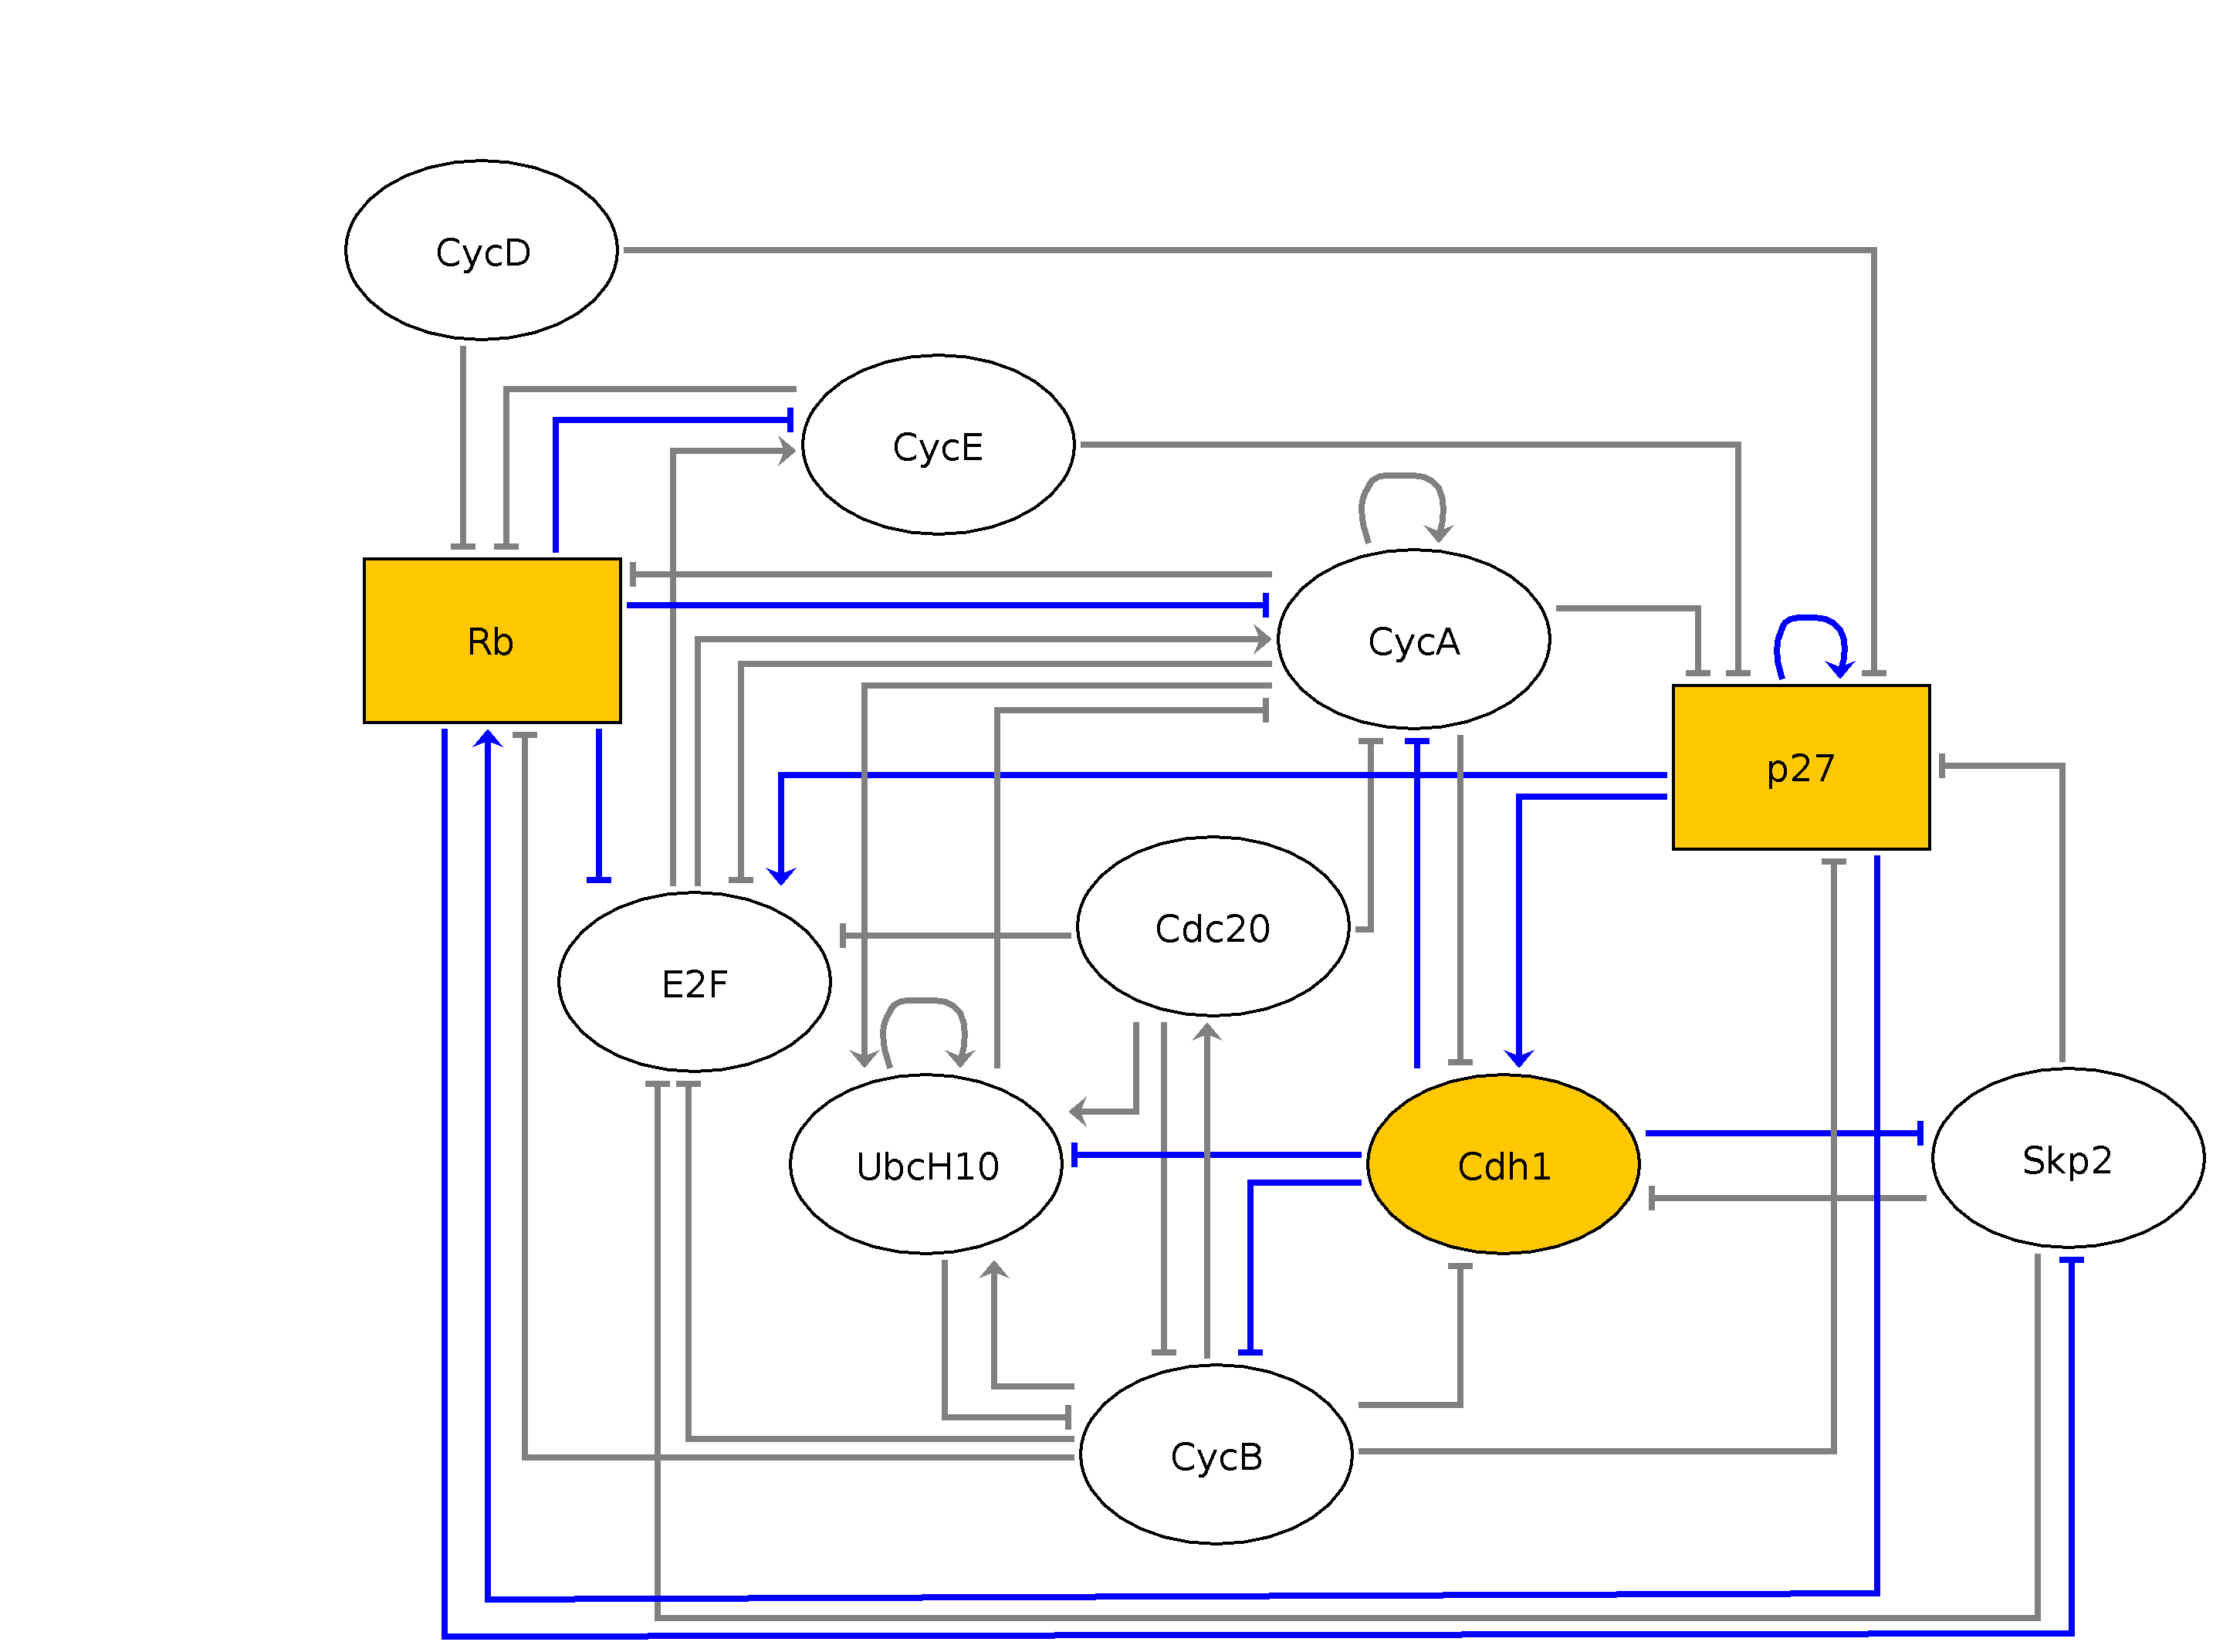

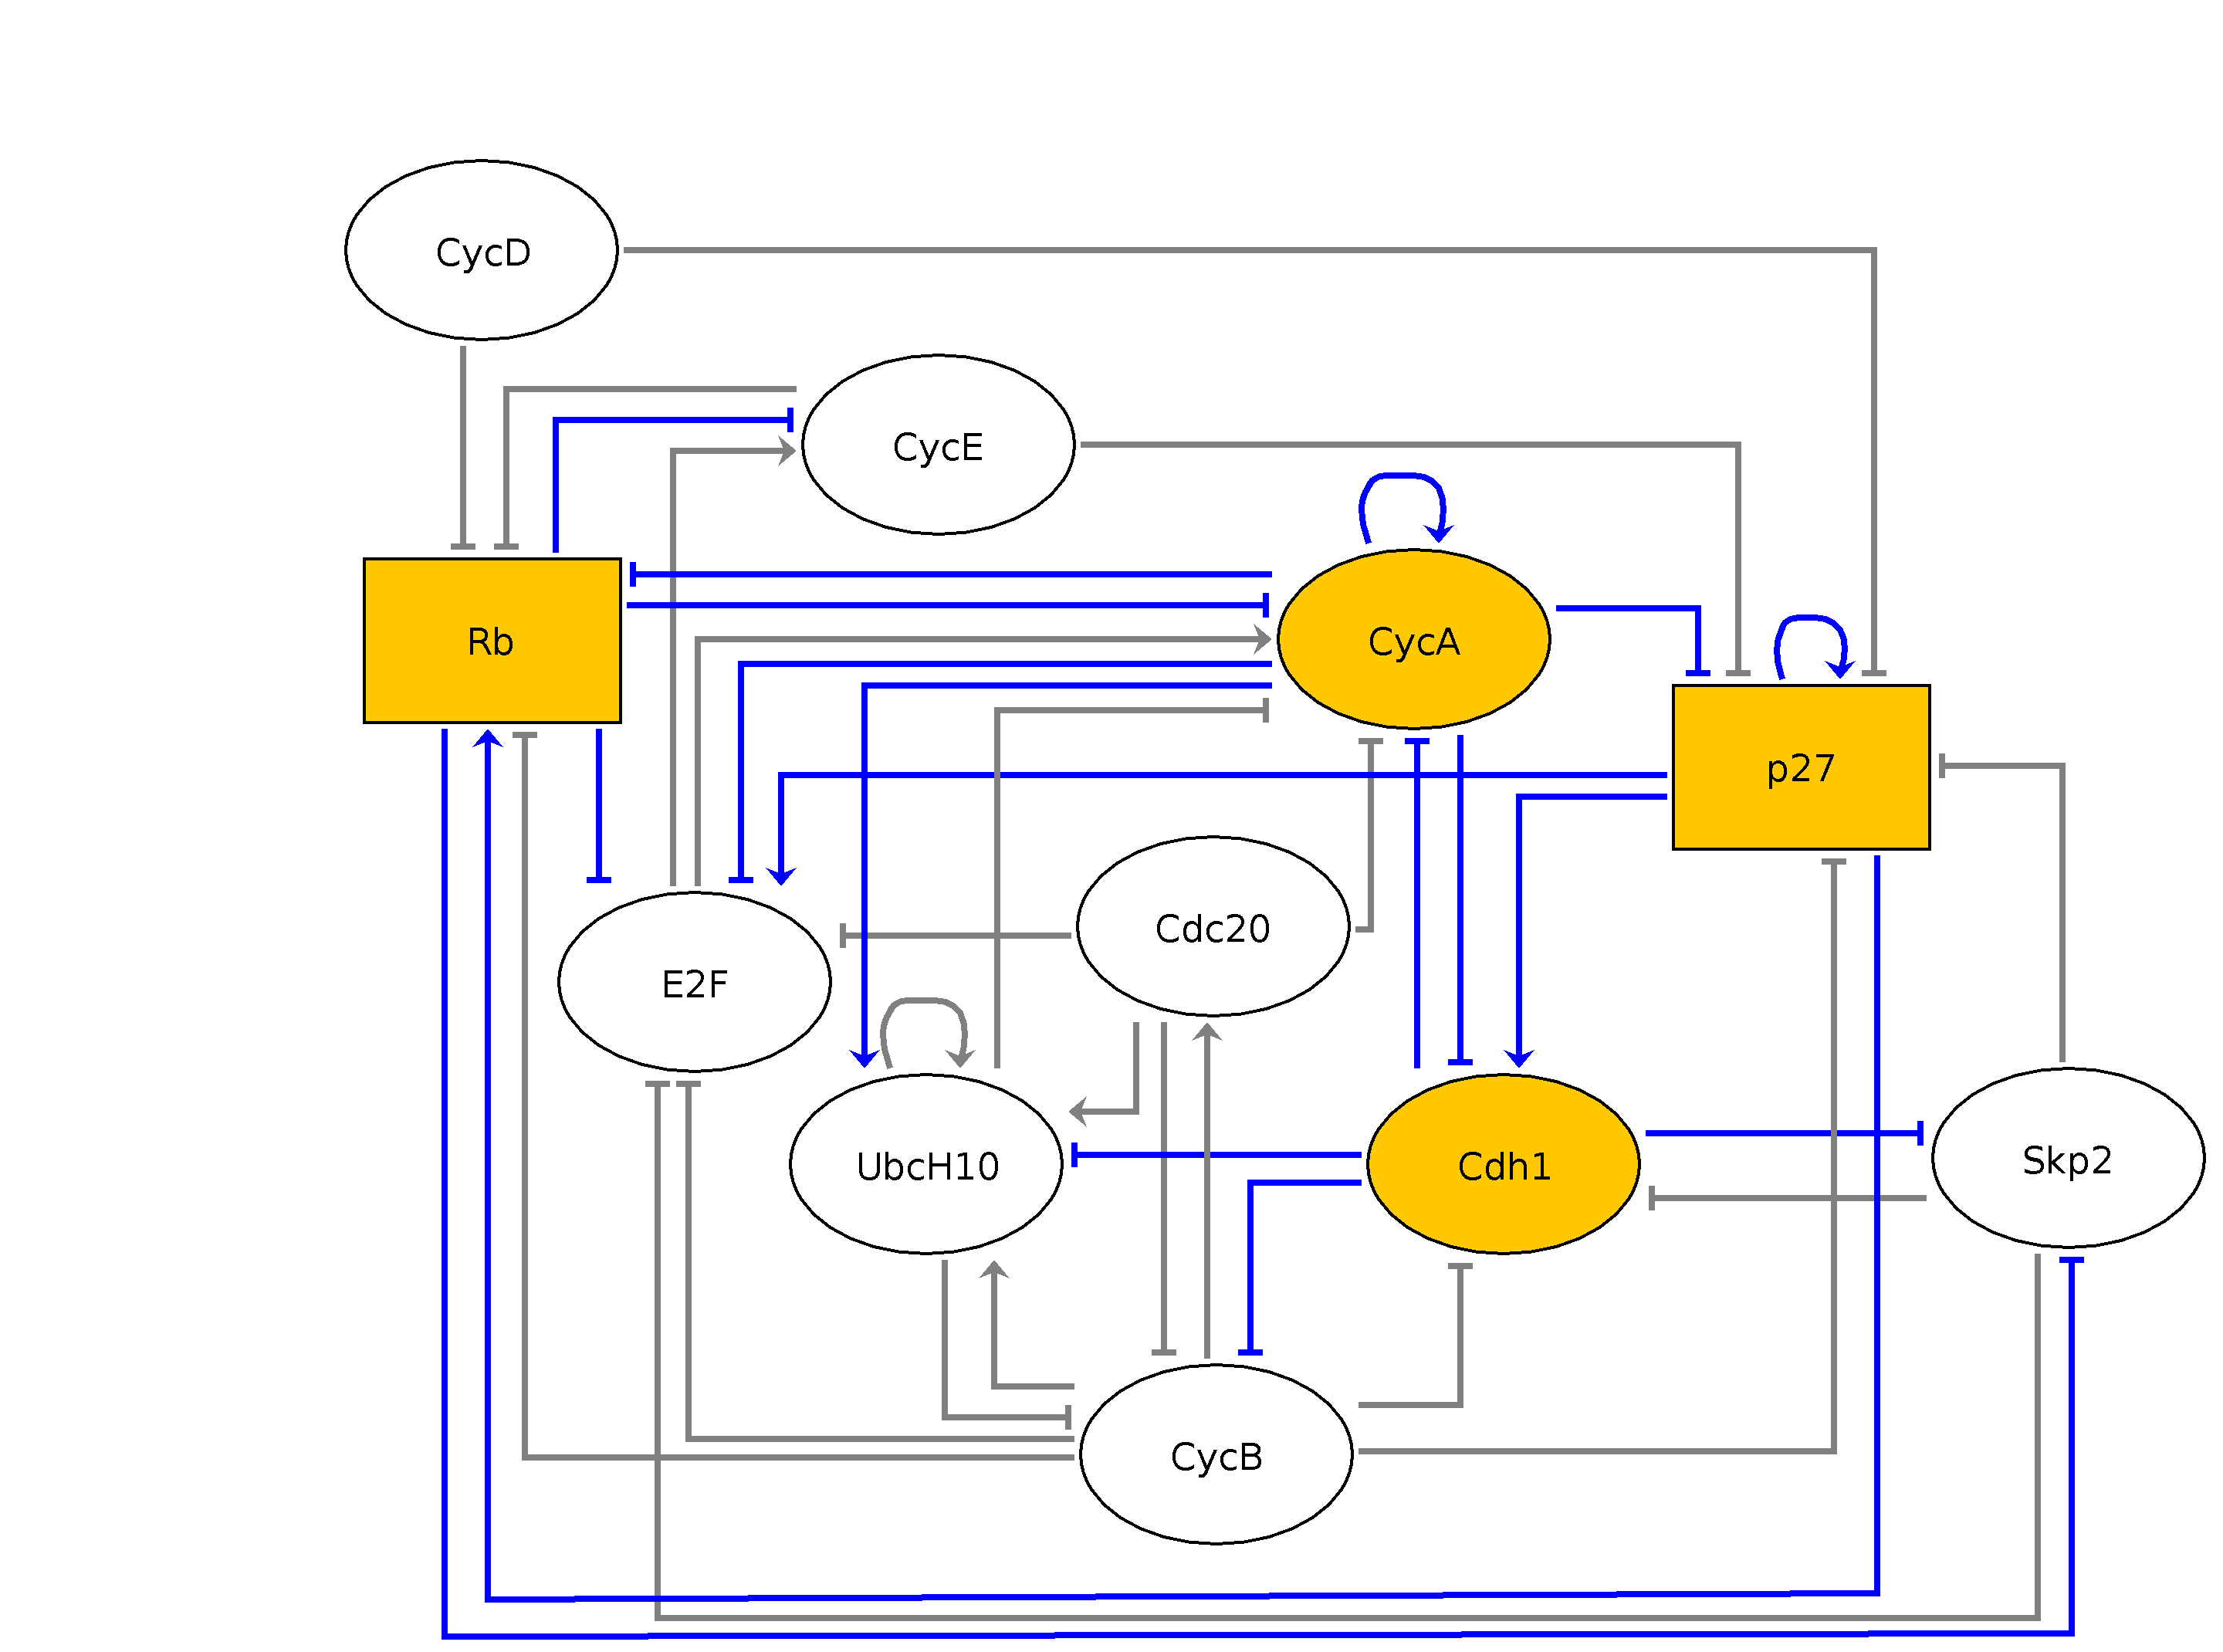

In [87]:
'''Compute stable states'''
fixpoints = biolqm.fixpoints(lqm)
tabulate(fixpoints)

'''Visualisation'''
sys.displayhook((ginsim.show(lrg, fixpoints[0])))
sys.displayhook((ginsim.show(lrg, fixpoints[1])))

As expected, we find the same stable states and can see in the graph that the inhibitors are active (yellow nodes), whereas all other nodes are inactif. So we are in the quiescent state.

With these two analysis, we managed to reproduce and confirm the results found by *Traynard et al.*

You can also visualise the stable state with our modified model (with outputs) *lrg_outputs*. There you directly see that the quiscent state (*Qo_arrest=1*) is active, whereas the cycle is not (*Proliferation=0*):

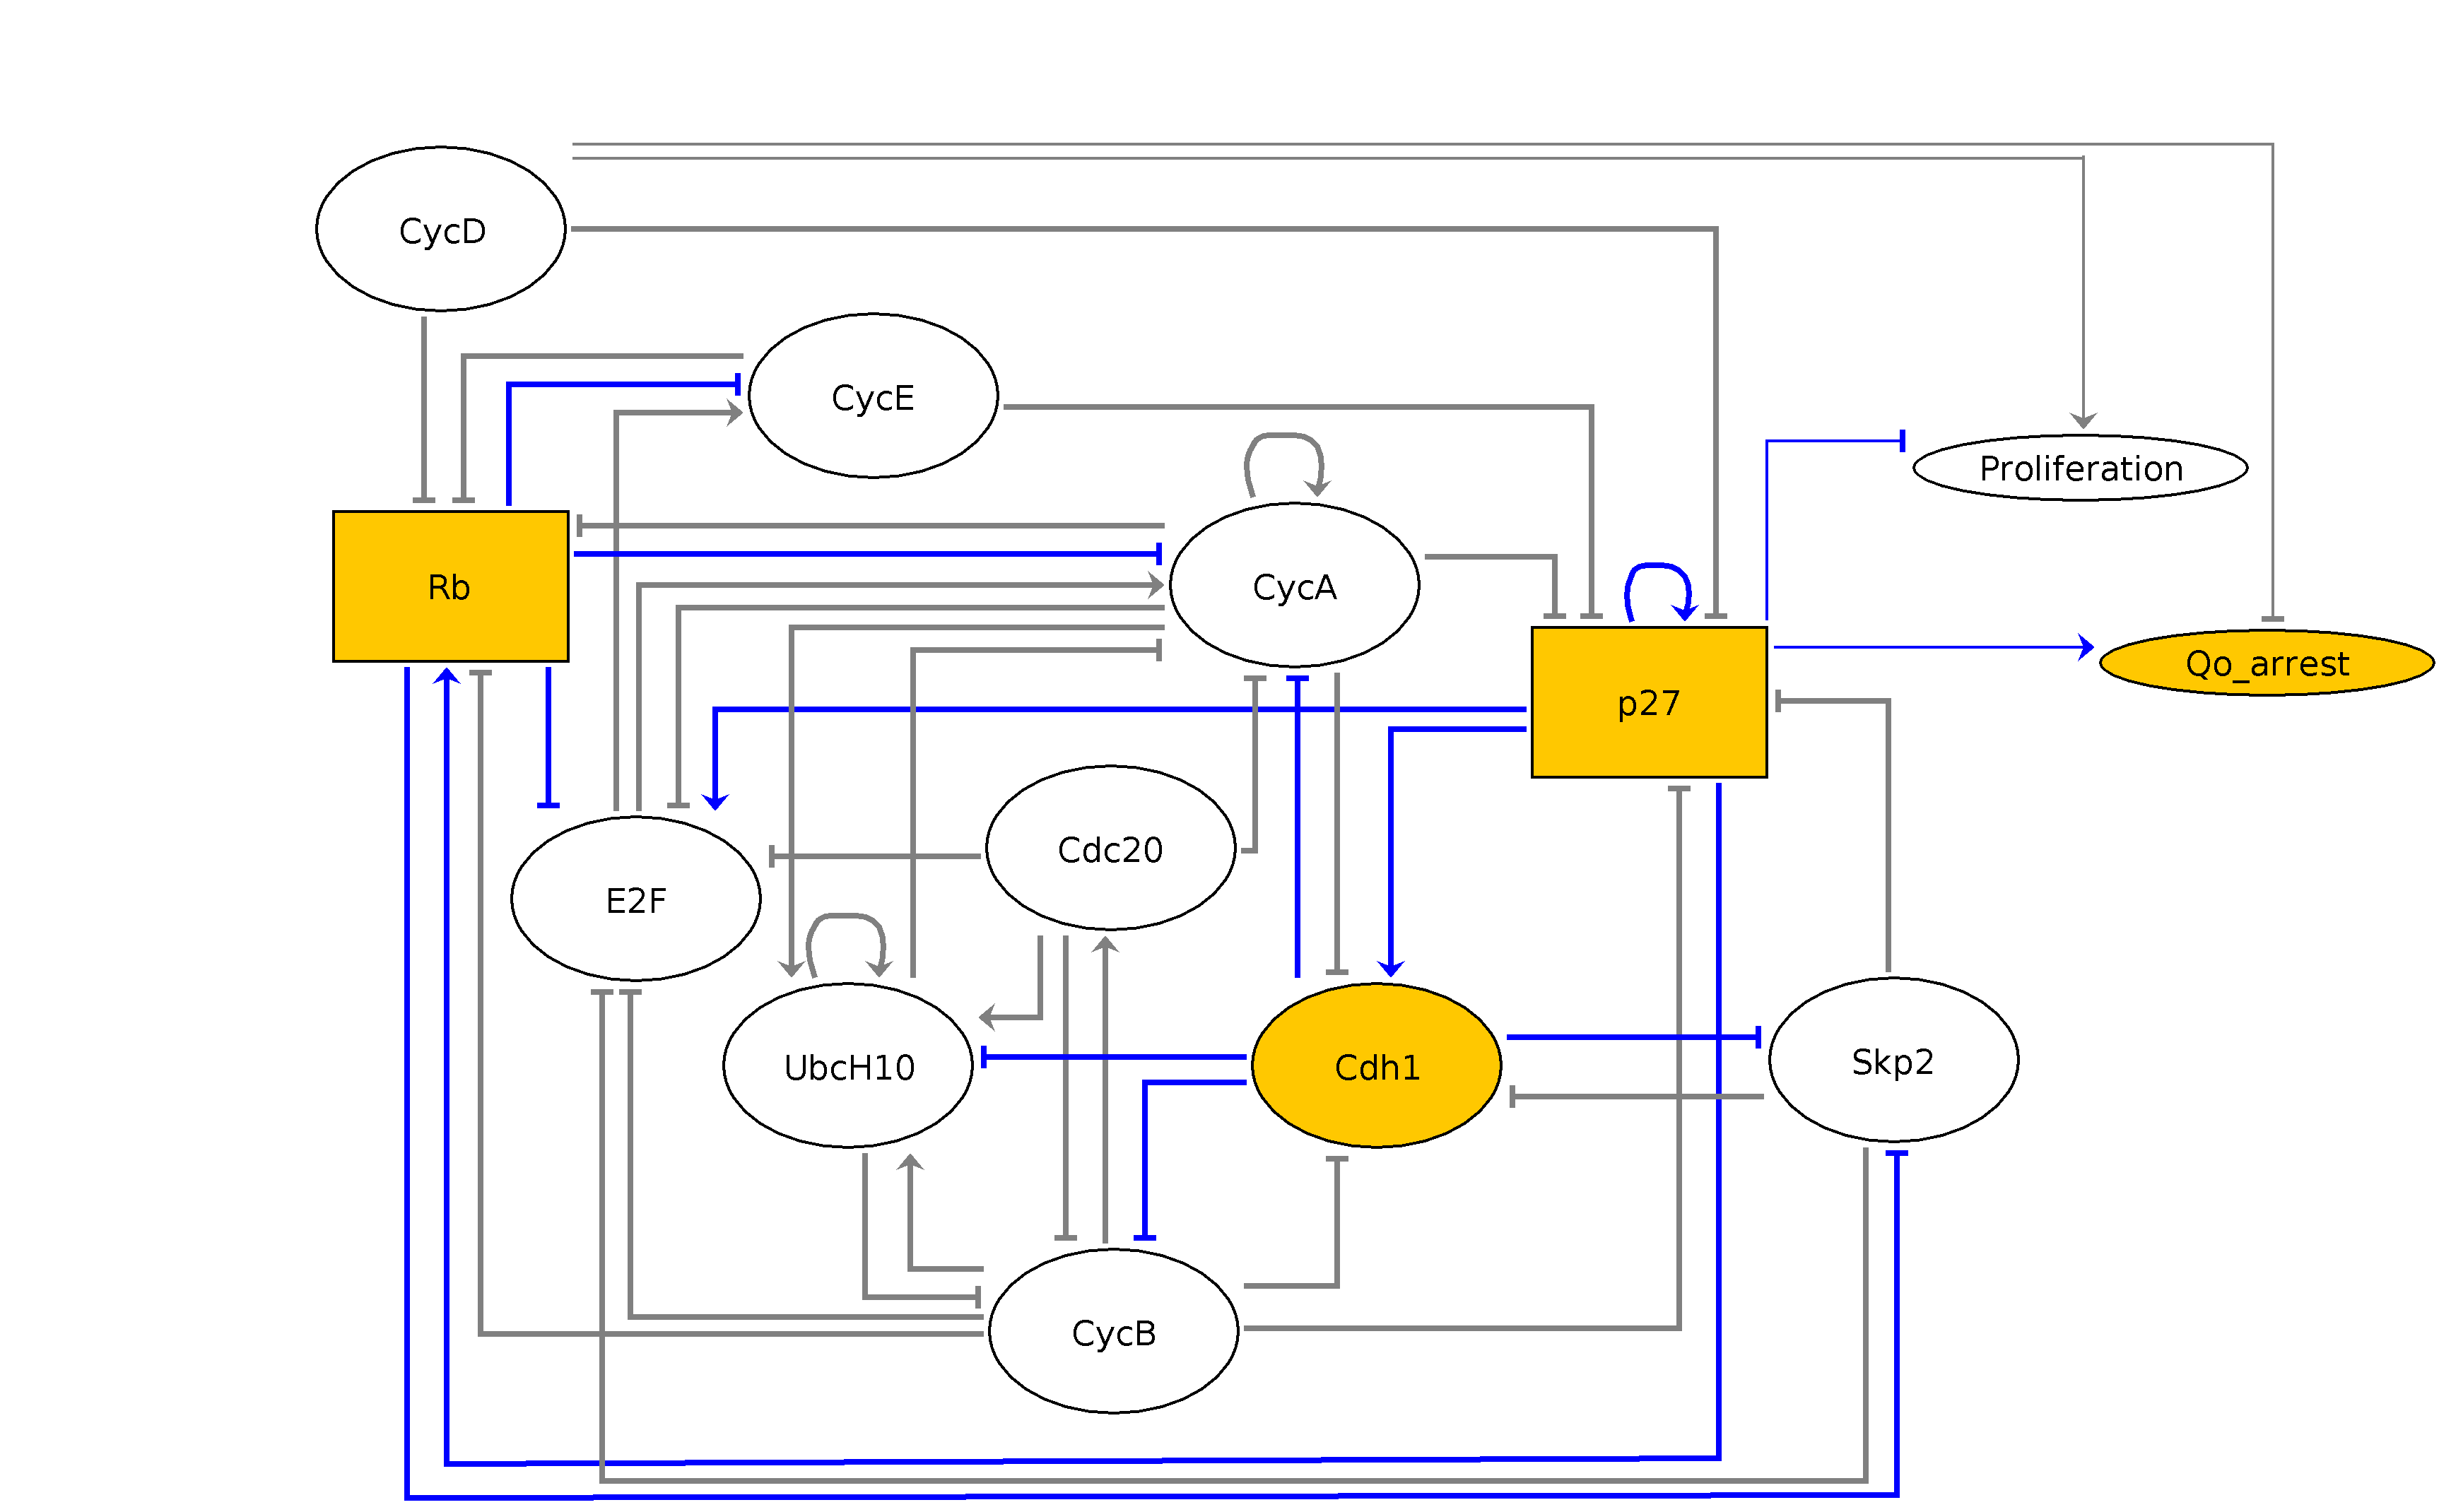

In [88]:
lqm2 = ginsim.to_biolqm(lrg_outputs)
fixpoints = biolqm.fixpoints(lqm2)
sys.displayhook((ginsim.show(lrg_outputs, fixpoints[0])))

### Perturbations analysis

Traynard et al. also analysed 20 experimental mutations (Knock-ins and Knock-outs) to test phenotypes observed in previous publications and to gain insights by comparing the non-mutated states (what we have computed above) and the mutated ones. The mutations are set as perturbations by either having 
* the node permanently ON: *node%1* - ectopic mutation
* the node permanently OFF: *node%0* - knock out mutation
* the effect of a node on another node ON or OFF: *node1:node2%0* - the effect of node2 to node1 is not taken into account in this perturbed model.

To reproduce this, we first apply a perturbation to the model and then try to find the attractors of this perturbed model. The first example below shows how to do one perturbation and compute it's trap space. 
As we have 20 of them to test, we decided to automatise the process by storing the list of perturbations in a python object. We also chose to present the results in a clustered heatmap for better clarity.

#### Single ectopic perturbation example:


In [5]:
ectopic_cyce = biolqm.perturbation(lqm,"CycE%1")
tabulate(biolqm.fixpoints(ectopic_cyce))
tabulate(biolqm.trapspace(ectopic_cyce))

|    |   CycD |   Rb_b1 |   Rb_b2 |   E2F |   CycE |   CycA |   CycB |   p27_b1 |   p27_b2 |   Cdc20 |   Cdh1 |   UbcH10 |   Skp2 |
|---:|-------:|--------:|--------:|------:|-------:|-------:|-------:|---------:|---------:|--------:|-------:|---------:|-------:|
|  0 |      1 |       0 |       0 |   255 |      1 |    255 |    255 |        0 |        0 |     255 |    255 |      255 |      1 |
|  1 |      0 |       0 |       0 |   255 |      1 |    255 |    255 |        0 |        0 |     255 |    255 |      255 |      1 |
|  2 |      0 |       1 |       1 |     0 |      1 |      0 |      0 |        1 |        1 |       0 |      1 |        0 |      0 |
|  3 |      0 |       1 |       1 |     0 |      1 |      1 |      0 |        1 |        1 |       0 |      1 |        0 |      0 |

When knocking in CycE's activity in the model, we observe 4 reachable attractors:
* one cycle where CycD = 1. We are most likely in a cell cycle,
* two stable states where CycD = 0 and we still observe this limitation with CycA. We are most likely in a quiescent state,
* one cycle where CycD = 0. We can question here if the model is cycling in the quiescent state.

#### Automated testing of perturbations:

Given a list of perturbations, written in a understanble way for bioLQM, we create a perturbed model for each perturbation, then compute a trap space analysis and store all data under a data frame where the columns represent the nodes of the model and the rows represent the mutations.

In [4]:
'''list of perturbations to test. This list can be modified to test other mutations'''
perturbations = ["CycE%1", 
                 "p27%1", 
                 "p27%1 CycA%1", 
                 "p27%1 CycE%1", 
                 "p27%1 E2F%1",
                 "Rb%2", 
                 "Cdh1%0", 
                 "Rb%0", 
                 "Rb%0 E2F%1", 
                 "E2F%1 Rb%1 CycE:Rb%0 CycA:Rb%0", 
                 "CycE%0",
                 "CycE%0 CycA%0", 
                 "UbcH10%0", 
                 "Rb%1 E2F:Rb%0 CycE:Rb%0 CycA:Rb%0", 
                 "E2F:Rb%0 CycE:Rb%0 CycA:Rb%0", 
                 "Skp2%0", 
                 "Skp2%0 p27%0", 
                 "Skp2%1 Rb%2 E2F:Rb%0 CycE:Rb%0 CycA:Rb%0", 
                 "Rb%1 p27%0 E2F:Rb%0 CycE:Rb%0 CycA:Rb%0",
                 "p27%0"]

In [35]:
'''Define dictionaries to store attractors for each perturbation'''
fixpointlist = {}

'''trapspacelist is used for perturbations where no stable state is found
    to find eventual cyclic attractors.'''
trapspacelist = {}

for p in perturbations:
    fixpoints = biolqm.fixpoints(biolqm.perturbation(lqm, p))
    if(fixpoints):
        fixpointlist[p] = fixpoints
    else:
        '''No stable state found, so we look for cycles'''
        trapspace = biolqm.trapspace(biolqm.perturbation(lqm, p))
        trapspacelist[p] = trapspace

'''uncomment to see attractors in tabulated tables for each perturbation
for k, v in fixpointlist.items():
    print(k)
    sys.displayhook(tabulate(v))
    print()
    
for k, v in trapspacelist.items():
    print(k)
    sys.displayhook(tabulate(v))
    print()'''

'uncomment to see attractors in tables for each perturbation\nfor k, v in fixpointlist.items():\n    print(k)\n    sys.displayhook(tabulate(v))\n    print()\n    \nfor k, v in trapspacelist.items():\n    print(k)\n    sys.displayhook(tabulate(v))\n    print()'

Text(0.5,0.98,'Clustered heatmap of each stable states found for each perturbation')

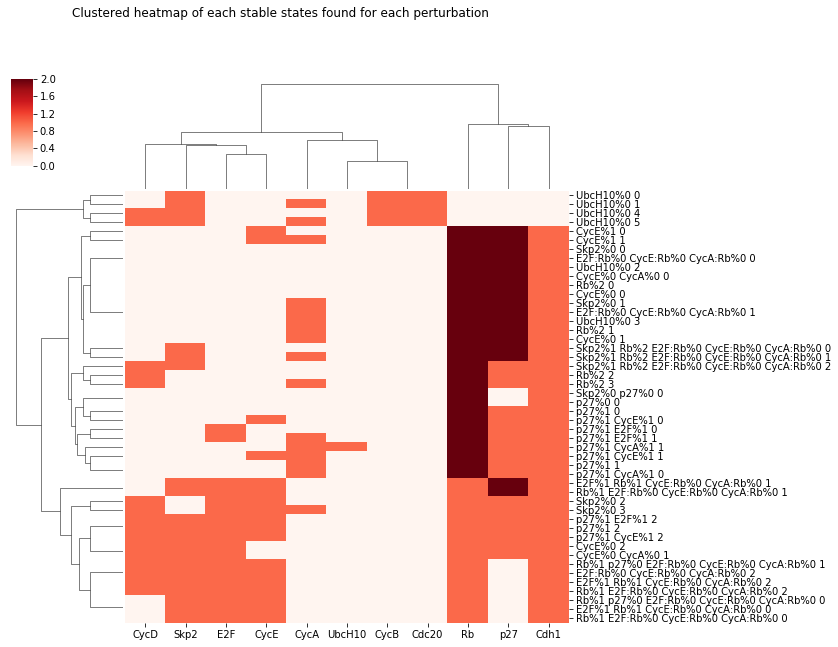

In [42]:
import seaborn as sns

'''List of perturbations with the nb of stable states '''
perturbstates=[]
trappedstates=[]

'''List of table state values same order as perturbStates, with '''
stablestates = [] 
tstates = [] 

'''List of nodes'''
nodelist = ['CycD', 'Rb', 'E2F', 'CycE', 'CycA', 'CycB', 'p27', 'Cdc20', 'Cdh1', 'UbcH10', 'Skp2']

for k,v in fixpointlist.items():   
    for i in range(0,len(v)):
        listSS = []
        for key, val in v[i].items():
            listSS.append(val)
        stablestates.append(listSS)
        perturbstates.append(str(k)+' '+str(i))

'''Create dataframe: columns = nodes, rows = perturbations'''
df = DataFrame(data=stablestates)
df.columns = nodelist
df.index = perturbstates

'''Generate clustered heatmap'''
cm = sns.clustermap(df, metric='euclidean', cmap = 'Reds', yticklabels=True)
cm.fig.suptitle('Clustered heatmap of each stable states found for each perturbation')

Text(0.5,0.98,'Clustered heatmap of each cyclic attractors found for perturbations not leading to a stable state')

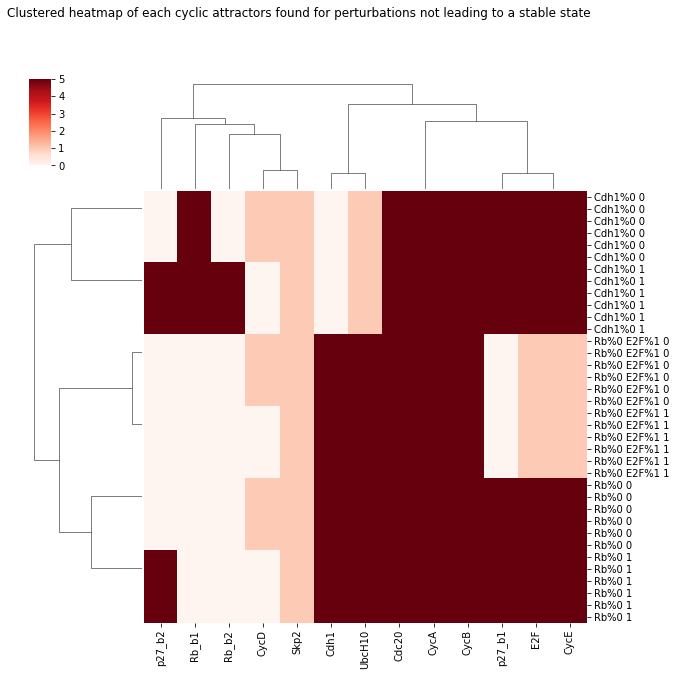

In [48]:
'''Repeat previous analysis for the trap space data'''
for k,v in trapspacelist.items():   
    for i in range(0,len(v)):
        listSS = []
        for key, val in v[i].items():
            if val == 255:
                val = 5
            listSS.append(val)
        tstates.append(listSS)
        trappedstates.append(str(k)+' '+str(i))

'''List of nodes in the trap space: multi valued components are expanded into several nodes'''        
nodelistT = ['CycD', 'Rb_b1', 'Rb_b2', 'E2F', 'CycE', 'CycA', 'CycB', 'p27_b1', 'p27_b2', 'Cdc20', 'Cdh1', 'UbcH10', 'Skp2']

df2 = DataFrame(data=tstates)
df2.columns = nodelistT
df2.index = trappedstates
cm2 = sns.clustermap(df2, metric='euclidean', cmap = 'Reds', yticklabels=True)
cm2.fig.suptitle('Clustered heatmap of each cyclic attractors found for perturbations not leading to a stable state')


For unfixed node states (nodes oscillating between 0 and 1), bioLQM set their value to 255. Thus, for readability reasons of the heatmap, we decided to change this value to 5 to have a low range of gradient values. This way, we are able to distinguish clearly when the nodes are ON or OFF (value 1 or 0) and when the nodes are oscillating (value 5).

### Testing stable state reachability from a mutated initial state (PINT, MABOSS)

Biological question: is it possible to reach the quiescent state from the perturbations/mutations tested in the paper?


In [41]:
perturbations = ["CycE%1", 
                 "p27%1",                 
                 "p27%1 CycA%1", 
                 "p27%1 CycE%1", 
                 "p27%1 E2F%1",
                 "Rb%2", 
                 "Cdh1%0", 
                 "Rb%0", 
                 "Rb%0 E2F%1", 
                 "CycE%0",
                 "CycE%0 CycA%0", 
                 "UbcH10%0", 
                 "Skp2%0", 
                 "Skp2%0 p27%0",
                 "p27%0"]

for perturb in perturbations:
    lock_dict = {}
    py_model = biolqm.to_pint(lqm)
    for mutation in perturb.split():
        '''Pint settings'''
        py_model.initial_state[mutation.split('%')[0]] = int(mutation.split("%")[1])
        lock_dict[mutation.split('%')[0]] = int(mutation.split("%")[1])

    print(display(tabulate(py_model.lock(lock_dict).reachable_attractors())))
    print(lock_dict, "reaches quiescent state: \t", py_model.lock(lock_dict).reachability("CycD=0"))

    print()

|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 1, 'CycA': 0, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |
|  1 | cyclic   |     30 | {'CycD': 0, 'Rb': 0, 'E2F': 0, 'CycE': 1, 'CycA': 0, 'CycB': 1, 'p27': 0, 'Cdc20': 0, 'Cdh1': 0, 'UbcH10': 1, 'Skp2': 1} |
|  2 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 1, 'CycA': 1, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'CycE': 1} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 1, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |
|  1 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 1, 'CycB': 0, 'p27': 1, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'p27': 1} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 1, 'CycB': 0, 'p27': 1, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |
|  1 | cyclic   |      4 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 1, 'CycB': 0, 'p27': 1, 'Cdc20': 0, 'Cdh1': 0, 'UbcH10': 1, 'Skp2': 1} |
|  2 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 1, 'CycB': 0, 'p27': 1, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 1, 'Skp2': 0} |

None
{'p27': 1, 'CycA': 1} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 1, 'CycA': 0, 'CycB': 0, 'p27': 1, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |
|  1 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 1, 'CycA': 1, 'CycB': 0, 'p27': 1, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'p27': 1, 'CycE': 1} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 1, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 1, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |
|  1 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 1, 'CycE': 0, 'CycA': 1, 'CycB': 0, 'p27': 1, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'p27': 1, 'E2F': 1} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'Rb': 2} reaches quiescent state: 	 True



|    | type   |   size | sample                                                                                                                   |
|---:|:-------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | cyclic |    288 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 0, 'UbcH10': 1, 'Skp2': 1} |

None
{'Cdh1': 0} reaches quiescent state: 	 True



|    | type   |   size | sample                                                                                                                   |
|---:|:-------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | cyclic |    296 | {'CycD': 0, 'Rb': 0, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 1} |

None
{'Rb': 0} reaches quiescent state: 	 True



|    | type   |   size | sample                                                                                                                   |
|---:|:-------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | cyclic |     15 | {'CycD': 0, 'Rb': 0, 'E2F': 1, 'CycE': 1, 'CycA': 1, 'CycB': 0, 'p27': 0, 'Cdc20': 0, 'Cdh1': 0, 'UbcH10': 0, 'Skp2': 1} |

None
{'Rb': 0, 'E2F': 1} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |
|  1 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 1, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'CycE': 0} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'CycE': 0, 'CycA': 0} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |
|  1 | fixpoint |      1 | {'CycD': 0, 'Rb': 0, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 1, 'p27': 0, 'Cdc20': 1, 'Cdh1': 0, 'UbcH10': 0, 'Skp2': 1} |
|  2 | fixpoint |      1 | {'CycD': 0, 'Rb': 0, 'E2F': 0, 'CycE': 0, 'CycA': 1, 'CycB': 1, 'p27': 0, 'Cdc20': 1, 'Cdh1': 0, 'UbcH10': 0, 'Skp2': 1} |
|  3 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 1, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'UbcH10': 0} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |
|  1 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 1, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'Skp2': 0} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 0, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'Skp2': 0, 'p27': 0} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 0, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'p27': 0} reaches quiescent state: 	 True



In [11]:
mab_model = ginsim.to_maboss(lrg)
mab_model.mutate('CycA', 'ON')
mab_model.mutate('p27_b1', 'ON')
mab_model.mutate('p27_b2', 'OFF')


In [12]:
mut_results = mab_model.run()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (23,26,29,32,35,38,41,44,47,50,53,56,59,62,65,68,71,74,77,80,83,86,89,92,95,98,101,104,107,110,113,116,119,122,125,128,131,134,137,140,143,146,149,152,155,158,161,164,167,170,173,176,179,182,185,188,191,194,197,200,203,206,209,212,215,218,221,224,227,230,233,236,239,242,245,248,251,254,257,260,263,266,269,272,275,278,281,284,287,290,293,296,299,302,305,308,311,314,317,320,323,326,329,332,335,338,341,344,347,350,353,356,359,362,365,368,371,374,377,380,383,386,389,392,395,398,401,404,407,410,413,416,419,422,425,428,431,434,437,440,443,446,449,452,455,458,461,464,467,470,473,476,479,482,485,488,491,494,497,500,503,506,509,512,515,518,521,524,527,530,533,536,539,542,545,548,551,554,557,560,563,566,569,572,575,578,581,584,587,590,593,596,599,602,605,608,611,614,617,620,623,626,629,632,635,638,641,644,647,650,653,656,659,662,665,668,671,674,677,680,683,686,689,692,695,698,701,704,707,710,713,7

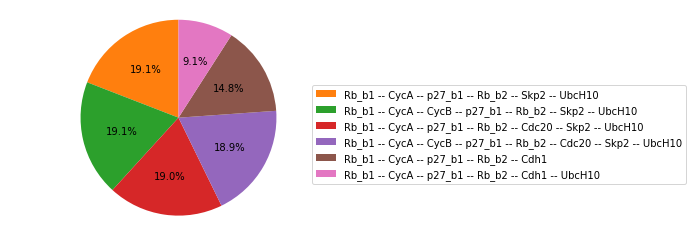

In [13]:
mut_results.plot_piechart()

### Finding mutations that prevent the quiscent state (PINT, MABOSS)

In [14]:
wt_sim = biolqm.to_maboss(lqm)

In [15]:
wt_sim.network.set_istate("CycD", [0.5,0.5])

In [16]:
wt_sim.update_parameters(max_time=50)

In [17]:
wt_res = wt_sim.run()

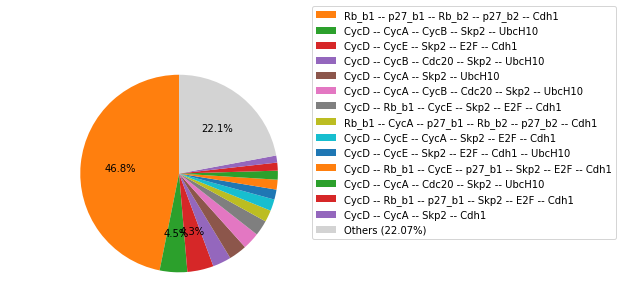

In [18]:
wt_res.plot_piechart()

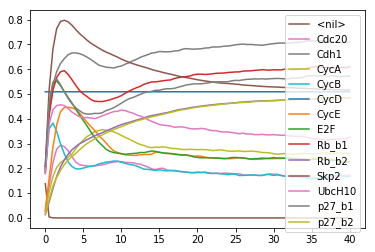

In [19]:
wt_res.plot_node_trajectory(until=40)

In [20]:
m = biolqm.to_pint(lqm)

In [21]:
m.initial_state["CycD"] = 0

In [22]:
mutants = m.oneshot_mutations_for_cut("Rb=2, p27=1, Cdh1=1")
mutants

This computation is an *under-approximation*: returned mutations are all valid, but they may be non-minimal, and some solutions may be missed.

Limiting solutions to mutations of at most 5 automata. Use `maxsize` argument to change.

[{'CycD': 1},
 {'CycE': 1, 'Skp2': 1},
 {'CycA': 1, 'Skp2': 1},
 {'CycB': 1, 'Skp2': 1},
 {'CycE': 1, 'CycA': 1, 'CycB': 1}]

In [23]:
mutants_comb = [combinations(m.items(),2) for m in mutants if len(m) >= 2]
candidates = reduce(set.union, mutants_comb, set())
candidates

{(('CycA', 1), ('CycB', 1)),
 (('CycA', 1), ('Skp2', 1)),
 (('CycB', 1), ('Skp2', 1)),
 (('CycE', 1), ('CycA', 1)),
 (('CycE', 1), ('CycB', 1)),
 (('CycE', 1), ('Skp2', 1))}

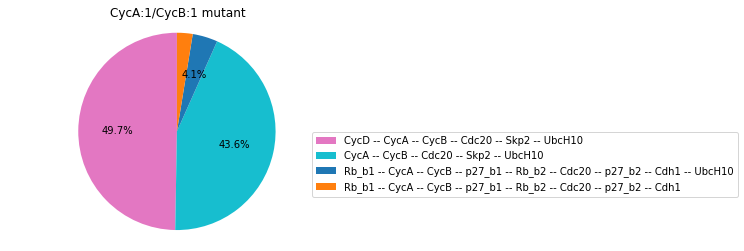

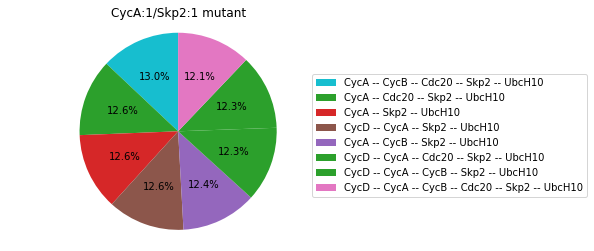

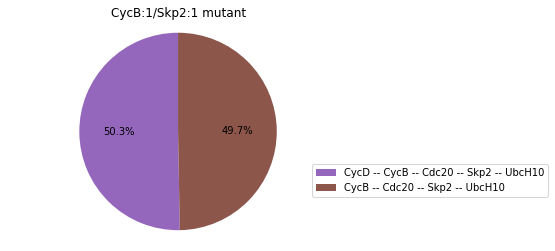

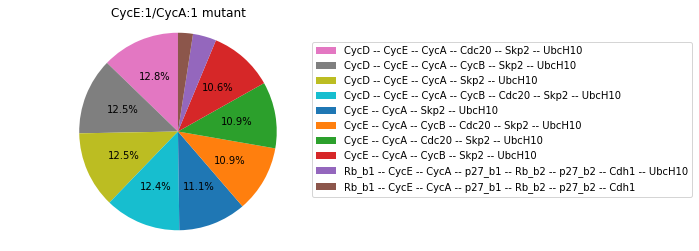

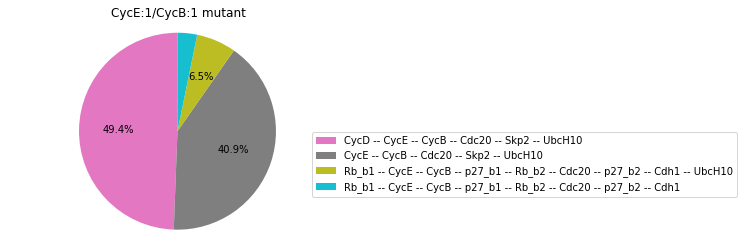

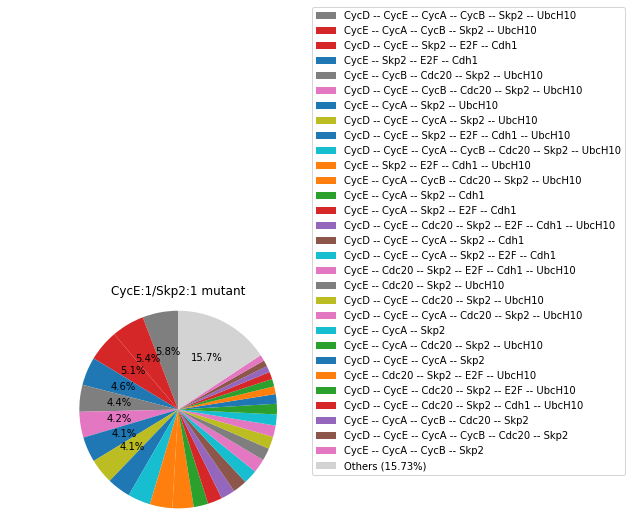

In [24]:
for mutant in sorted(candidates):
    mut_sim = wt_sim.copy()
    for (node, value) in mutant:
        mut_sim.mutate(node, "ON" if value else "OFF")
    mut_res = mut_sim.run()
    mut_res.plot_piechart(embed_labels=False, autopct=4)
    mutant_name = "/".join(["%s:%s"%m for m in mutant])
    plt.title("%s mutant" %mutant_name)
    

### Verification of biological properties through model checking (nuSMV)

In [25]:
lqm = ginsim.to_biolqm(lrg)

In [26]:
smv_cycle = """Cycle1 := (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1)| (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1);"""
smv = ginsim.to_nusmv(lrg)
smv.add_instruction(smv_cycle)

In [27]:
"""Define initial states"""
initial_G1 = S(CycE=0,CycA=0,CycB=0,Rb=1,p27=1,Cdh1=1,Cdc20=0,UbcH10=0,E2F=0)
initial_G2 = S(CycE=0,CycA=1,CycB=0,Rb=0,p27=0,Cdh1=0,Cdc20=0,UbcH10=0,E2F=0)

In [28]:
"""Sequential activation of Cyclins"""
Cyclin_activation = "!E[(CycE=0 & CycA=0 & CycB=0  & Cycle1) U ( CycE=1 & CycA=0 & CycB=0  & Cycle1 & E[( CycE=1 & CycA=0 & CycB=0  & Cycle1) U ( CycE=1 & CycA=1 & CycB=0  & Cycle1 & E[( CycE=1 & CycA=1 & CycB=0  & Cycle1) U ( CycE=0 & CycA=1 & CycB=0  & Cycle1 & E[( CycE=0 & CycA=1 & CycB=0  & Cycle1) U ( CycE=0 & CycA=1 & CycB=1  & Cycle1 & E[( CycE=0 & CycA=1 & CycB=1  & Cycle1) U ( CycE=0 & CycA=0 & CycB=1  & Cycle1 & E[( CycE=0 & CycA=0 & CycB=1  & Cycle1) U ( CycE=0 & CycA=0 & CycB=0  & Cycle1)])])])])])]"

"""Complete removal of CycB is required to prevent spindle checkpoint"""
CycB_removal = "!E[(CycE=0 & CycA=0 & CycB=0  & Cycle1) U ( CycE=1 & CycA=0 & CycB=0  & Cycle1 & E[( CycE=1 & CycA=0 & CycB=0  & Cycle1) U ( CycE=1 & CycA=1 & CycB=0  & Cycle1 & E[( CycE=1 & CycA=1 & CycB=0  & Cycle1) U ( CycE=0 & CycA=1 & CycB=0  & Cycle1 & E[( CycE=0 & CycA=1 & CycB=0  & Cycle1) U ( CycE=0 & CycA=1 & CycB=1  & Cycle1 & E[( CycE=0 & CycA=1 & CycB=1  & Cycle1) U ( CycE=0 & CycA=0 & CycB=1  & Cycle1 & E[( CycE=0 & CycA=0 & CycB=1  & Cycle1) U ( CycE=1 & CycA=0 & CycB=0  & Cycle1)])])])])])]"

"""Irreversability of S-phase initiation / Correct order starting from G1""" 
Irreversible_S_correct = "!E[(CycE=0 & CycA=0 & p27=1 & Cycle1) U ( CycE=0 & CycA=0 & p27=1 & Cycle1 & E[( CycE=0 & CycA=0 & p27=1 & Cycle1) U ( CycE=1 & CycA=0 & p27=1 & Cycle1 & E[( CycE=1 & CycA=0 & p27=1 & Cycle1) U ( CycE=1 & CycA=0 & p27=0 & Cycle1 & E[( CycE=1 & CycA=0 & p27=0 & Cycle1) U ( CycE=1 & CycA=1 & p27=0 & Cycle1 & E[( CycE=1 & CycA=1 & p27=0 & Cycle1) U ( CycE=0 & CycA=1 & p27=0 & Cycle1 & E[( CycE=1 & CycA=1 & p27=0 & Cycle1) U (CycE=0 & CycA=1 & p27=0 & Cycle1)])])])])])]"

""""Incorrect sequence starting from G1 (p27 inhibited without CycE)"""
Irreversible_S_incorrect = "!E[(CycE=0 & CycA=0 & p27=1  & Cycle1) U ( CycE=0 & CycA=0 & p27=0  & Cycle1 & E[( CycE=0 & CycA=0 & p27=0  & Cycle1) U ( CycE=1 & CycA=1 & p27=0  & Cycle1 & E[( CycE=1 & CycA=1 & p27=0  & Cycle1) U ( CycE=0 & CycA=1 & p27=0  & Cycle1)])])]"

"""Incorrect sequence starting from G1 (CycA activated before p27 inhibition)"""
Irreversible_S_incor2 = "!E[( CycE=0 & CycA=0 & p27=1 & Cycle1) U ( CycE=1 & CycA=0 & p27=1 & Cycle1 &E[(CycE=0 & CycA=0 & p27=1 & Cycle1) U (CycE=1 & CycA=1 & p27=1 & Cycle1)])]"

"""Degradation of B cyclins by the APC/C complex is required for mitosis to take place / Correct sequence starting from G2"""
CycB_degradation_G2 = "!E[(CycA=1 & CycB=0 & Cdc20=0 & Cycle1) U (CycA=1 & CycB=1 & Cdc20=0 & Cycle1 &E[(CycA=1 & CycB=1 & Cdc20=0 & Cycle1) U (CycA=1 & CycB=1 & Cdc20=1 & Cycle1 & E[(CycA=1 & CycB=1 & Cdc20=1 & Cycle1) U (CycA=0 & CycB=1 & Cdc20=1 & Cycle1 & E[(CycA=0 & CycB=1 & Cdc20=1 & Cycle1) U (CycA=0 & CycB=0 & Cdc20=1 & Cycle1 & E[(CycA=0 & CycB=0 & Cdc20=1 & Cycle1) U (CycA=0 & CycB=0 & Cdc20=0 & Cycle1)])])])])]"

"""Incorrect sequence from G2(inactivation of CycB without Cdc20)"""
CycB_without_Cdc20 = "!E[(CycA=1 & CycB=0 & Cdc20=0 & Cycle1) U (CycA=1 & CycB=1 & Cdc20=0 & Cycle1 &E[(CycA=1 & CycB=1 & Cdc20=0 & Cycle1) U (CycA=1 & CycB=1 & Cdc20=1 & Cycle1 & E[(CycA=1 & CycB=1 & Cdc20=1 & Cycle1) U (CycA=0 & CycB=1 & Cdc20=1 & Cycle1 & E[(CycA=0 & CycB=1 & Cdc20=1 & Cycle1) U (CycA=0 & CycB=1 & Cdc20=0 & Cycle1 & E[(CycA=0 & CycB=1 & Cdc20=0 & Cycle1) U (CycA=0 & CycB=0 & Cdc20=0 & Cycle1)])])])])]"

"""Incorrect sequence from G2 (inactivation of CycA without Cdc20)"""
CycA_without_Cdc20 = "!E[(CycA=1 & CycB=0 & Cdc20=0 & Cycle1) U (CycA=1 & CycB=1 & Cdc20=0 & Cycle1 & E[(CycA=1 & CycB=1 & Cdc20=0 & Cycle1) U (CycA=0 & CycB=1 & Cdc20=0 & Cycle1 & E[(CycA=0 & CycB=1 & Cdc20=0 & Cycle1) U (CycA=0 & CycB=0 & Cdc20=0 & Cycle1)])])]"



In [29]:
specs = {
    "Sequential_cyclin_activation": If(initial_G1, (Cyclin_activation)),
    "CycB_removal": If(initial_G1, (CycB_removal)),
    "Irreversible_S_correct": If(initial_G1, (Irreversible_S_correct)),
    "Irreversible_S_incorrect": If(initial_G1, (Irreversible_S_incorrect)),
    "Irreversible_S_incor2": If(initial_G1, (Irreversible_S_incor2)),
    "No_CycB_for_mitosis": If(initial_G2, (CycB_degradation_G2)),
    "CycB_without_Cdc20": If(initial_G2, (CycB_without_Cdc20)),
    "CycA_without_Cdc20": If(initial_G2, (CycA_without_Cdc20))
}

In [30]:
smv.add_ctls(specs)

In [31]:
smv.verify()

{'Sequential_cyclin_activation': False,
 'CycB_removal': True,
 'Irreversible_S_correct': False,
 'Irreversible_S_incorrect': True,
 'Irreversible_S_incor2': True,
 'No_CycB_for_mitosis': False,
 'CycB_without_Cdc20': True,
 'CycA_without_Cdc20': True}